In [13]:
import tensorboard
import tensorflow as tf
import keras 
import tensorflow_hub as hub
import tensorflow_text
import pandas as pd

In [14]:
import os
import shutil

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization  # to create AdamW optimizer

import matplotlib.pyplot as plt
import numpy as np

In [97]:
data = pd.read_csv('./Data/Dynasent/train.csv')

In [98]:
from sklearn.preprocessing import LabelBinarizer
encoder = LabelBinarizer()
transfomed_label = encoder.fit_transform(data['gold_label'])
data['gold_label'] = transfomed_label

# Save the encoder classes for later use
np.save('./Models/encoder.npy', encoder.classes_)

In [17]:
# data preprocessing
data['sentence'] = data['sentence'].apply(lambda x: x.lower())
data['sentence'] = data['sentence'].apply(lambda x: x.replace('\n', ' '))
data['sentence'] = data['sentence'].apply(lambda x: x.replace('\t', ' '))
data['sentence'] = data['sentence'].apply(lambda x: x.replace('\r', ' '))
data['sentence'] = data['sentence'].apply(lambda x: x.replace('\xa0', ' '))
data['sentence'] = data['sentence'].apply(lambda x: x.replace('\u200b', ' '))
data['sentence'] = data['sentence'].apply(lambda x: x.replace('\ufeff', ' '))

In [18]:
train_ds = tf.data.Dataset.from_tensor_slices((data['sentence'], data['gold_label']))

In [19]:
val_ds = pd.read_csv('./Data/Dynasent/valid.csv')

In [20]:
val_ds['sentence'] = val_ds['sentence'].apply(lambda x: x.lower())
val_ds['sentence'] = val_ds['sentence'].apply(lambda x: x.replace('\n', ' '))
val_ds['sentence'] = val_ds['sentence'].apply(lambda x: x.replace('\t', ' '))
val_ds['sentence'] = val_ds['sentence'].apply(lambda x: x.replace('\r', ' '))
val_ds['sentence'] = val_ds['sentence'].apply(lambda x: x.replace('\xa0', ' '))
val_ds['sentence'] = val_ds['sentence'].apply(lambda x: x.replace('\u200b', ' '))
val_ds['sentence'] = val_ds['sentence'].apply(lambda x: x.replace('\ufeff', ' '))

In [21]:
val_ds_label = encoder.transform(val_ds['gold_label'])
val_ds['gold_label'] = val_ds_label

val_ds = tf.data.Dataset.from_tensor_slices((val_ds['sentence'], val_ds['gold_label']))

In [22]:
AUTOTUNE = tf.data.AUTOTUNE
batch_size = 32
seed = 42

train_ds = train_ds.shuffle(buffer_size=len(data)).batch(batch_size)
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)

val_ds = val_ds.shuffle(buffer_size=len(val_ds)).batch(batch_size)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [23]:
tfhub_encoder = "https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4"
tfhub_prepocess = "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3"


In [24]:
# create the deep learning model to classify text into three categories
text_input = keras.Input(shape=(), dtype='string', name='text_input')
preprocessing_layer = hub.KerasLayer(tfhub_prepocess, name='Preprocessing_for_BERT')
encoder_inputs = preprocessing_layer(text_input)
encoder = hub.KerasLayer(tfhub_encoder, trainable=False, name='BERT_encoder')
outputs = encoder(encoder_inputs)
x = keras.layers.Dropout(0.2)(outputs['sequence_output'])
x = keras.layers.Dense(100, activation='relu')(x)
x = keras.layers.Dropout(0.2)(x)
x = keras.layers.Dense(100, activation='relu')(x)
x = keras.layers.Dropout(0.3)(x)
x = keras.layers.Dense(50, activation='relu')(x)
x = keras.layers.Dropout(0.35)(x)
x = keras.layers.Flatten()(x)
x = keras.layers.Dense(3, activation='softmax')(x)
model = keras.Model(inputs=[text_input], outputs=x)
model.compile(optimizer='adam',
                loss='sparse_categorical_crossentropy',             
                metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text_input (InputLayer)        [(None,)]            0           []                               
                                                                                                  
 Preprocessing_for_BERT (KerasL  {'input_type_ids':   0          ['text_input[0][0]']             
 ayer)                          (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128),                                                          
                                 'input_word_ids':                                                
                                (None, 128)}                                                  

In [25]:
epochs = 50
history = model.fit(train_ds,
                    validation_data=val_ds,
                    epochs=epochs,
                    verbose=1,
                    callbacks=[
                        keras.callbacks.TensorBoard(log_dir='./logs',
                                                    histogram_freq=1,
                                                    write_graph=True,
                                                    write_images=True),
                        keras.callbacks.EarlyStopping(patience=5,
                                                      monitor='val_loss')

                    ])


Epoch 1/50
2516/2516 [==============================] - 973s 383ms/step - loss: 0.3572 - accuracy: 0.8468 - val_loss: 0.4828 - val_accuracy: 0.7564
Epoch 2/50
2516/2516 [==============================] - 959s 381ms/step - loss: 0.3273 - accuracy: 0.8588 - val_loss: 0.4762 - val_accuracy: 0.7672
Epoch 3/50
2516/2516 [==============================] - 955s 379ms/step - loss: 0.3145 - accuracy: 0.8643 - val_loss: 0.4418 - val_accuracy: 0.7756
Epoch 4/50
2516/2516 [==============================] - 962s 382ms/step - loss: 0.3041 - accuracy: 0.8682 - val_loss: 0.4470 - val_accuracy: 0.7747
Epoch 5/50
2516/2516 [==============================] - 975s 388ms/step - loss: 0.2934 - accuracy: 0.8736 - val_loss: 0.4546 - val_accuracy: 0.7728
Epoch 6/50
2516/2516 [==============================] - 962s 382ms/step - loss: 0.2837 - accuracy: 0.8771 - val_loss: 0.4750 - val_accuracy: 0.7719
Epoch 7/50
2516/2516 [==============================] - 987s 392ms/step - loss: 0.2746 - accuracy: 0.8803 - val_

In [26]:
# load test data
test_ds = pd.read_csv('./Data/Dynasent/test.csv')


test_ds['sentence'] = test_ds['sentence'].apply(lambda x: x.lower())
test_ds['sentence'] = test_ds['sentence'].apply(lambda x: x.replace('\n', ' '))
test_ds['sentence'] = test_ds['sentence'].apply(lambda x: x.replace('\t', ' '))
test_ds['sentence'] = test_ds['sentence'].apply(lambda x: x.replace('\r', ' '))
test_ds['sentence'] = test_ds['sentence'].apply(lambda x: x.replace('\xa0', ' '))
test_ds['sentence'] = test_ds['sentence'].apply(lambda x: x.replace('\u200b', ' '))
test_ds['sentence'] = test_ds['sentence'].apply(lambda x: x.replace('\ufeff', ' '))

In [30]:
# transform the test data using the same encoder
test_ds_label = encoder.transform(test_ds['gold_label'])
test_ds['gold_label'] = test_ds_label

# create the test dataset
test_ds = tf.data.Dataset.from_tensor_slices((test_ds['sentence'], test_ds['gold_label']))

In [31]:
# create the test dataset
test_ds = test_ds.shuffle(buffer_size=len(test_ds)).batch(batch_size)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)


# evaluate the model
results = model.evaluate(test_ds, verbose=1, callbacks=[
    keras.callbacks.TensorBoard(log_dir='./logs',
                                histogram_freq=1,
                                write_graph=True,
                                write_images=True)]
)


# print the results
print('Test loss:', results[0])
print('Test accuracy:', results[1])

113/113 [==============================] - 40s 347ms/step - loss: 0.4763 - accuracy: 0.7836
Test loss: 0.4763326048851013
Test accuracy: 0.7836111187934875


In [58]:
# Test Model with Sample Test Data
text = 'There were members who do not contribute for the projects. Actually I do not prefer to work with a team'


# get prdiction from the model
prediction = model.predict([text])

In [59]:
encoder.inverse_transform(prediction)

array(['negative'], dtype='<U8')

In [71]:
model.save('model.pb')

INFO:tensorflow:Assets written to: model.pb\assets


INFO:tensorflow:Assets written to: model.pb\assets


In [68]:
#save the model
model.save('./Models/model1')

INFO:tensorflow:Assets written to: ./Models/model1\assets


INFO:tensorflow:Assets written to: ./Models/model1\assets


In [70]:
# load the model
model = keras.models.load_model('./Models/model1')

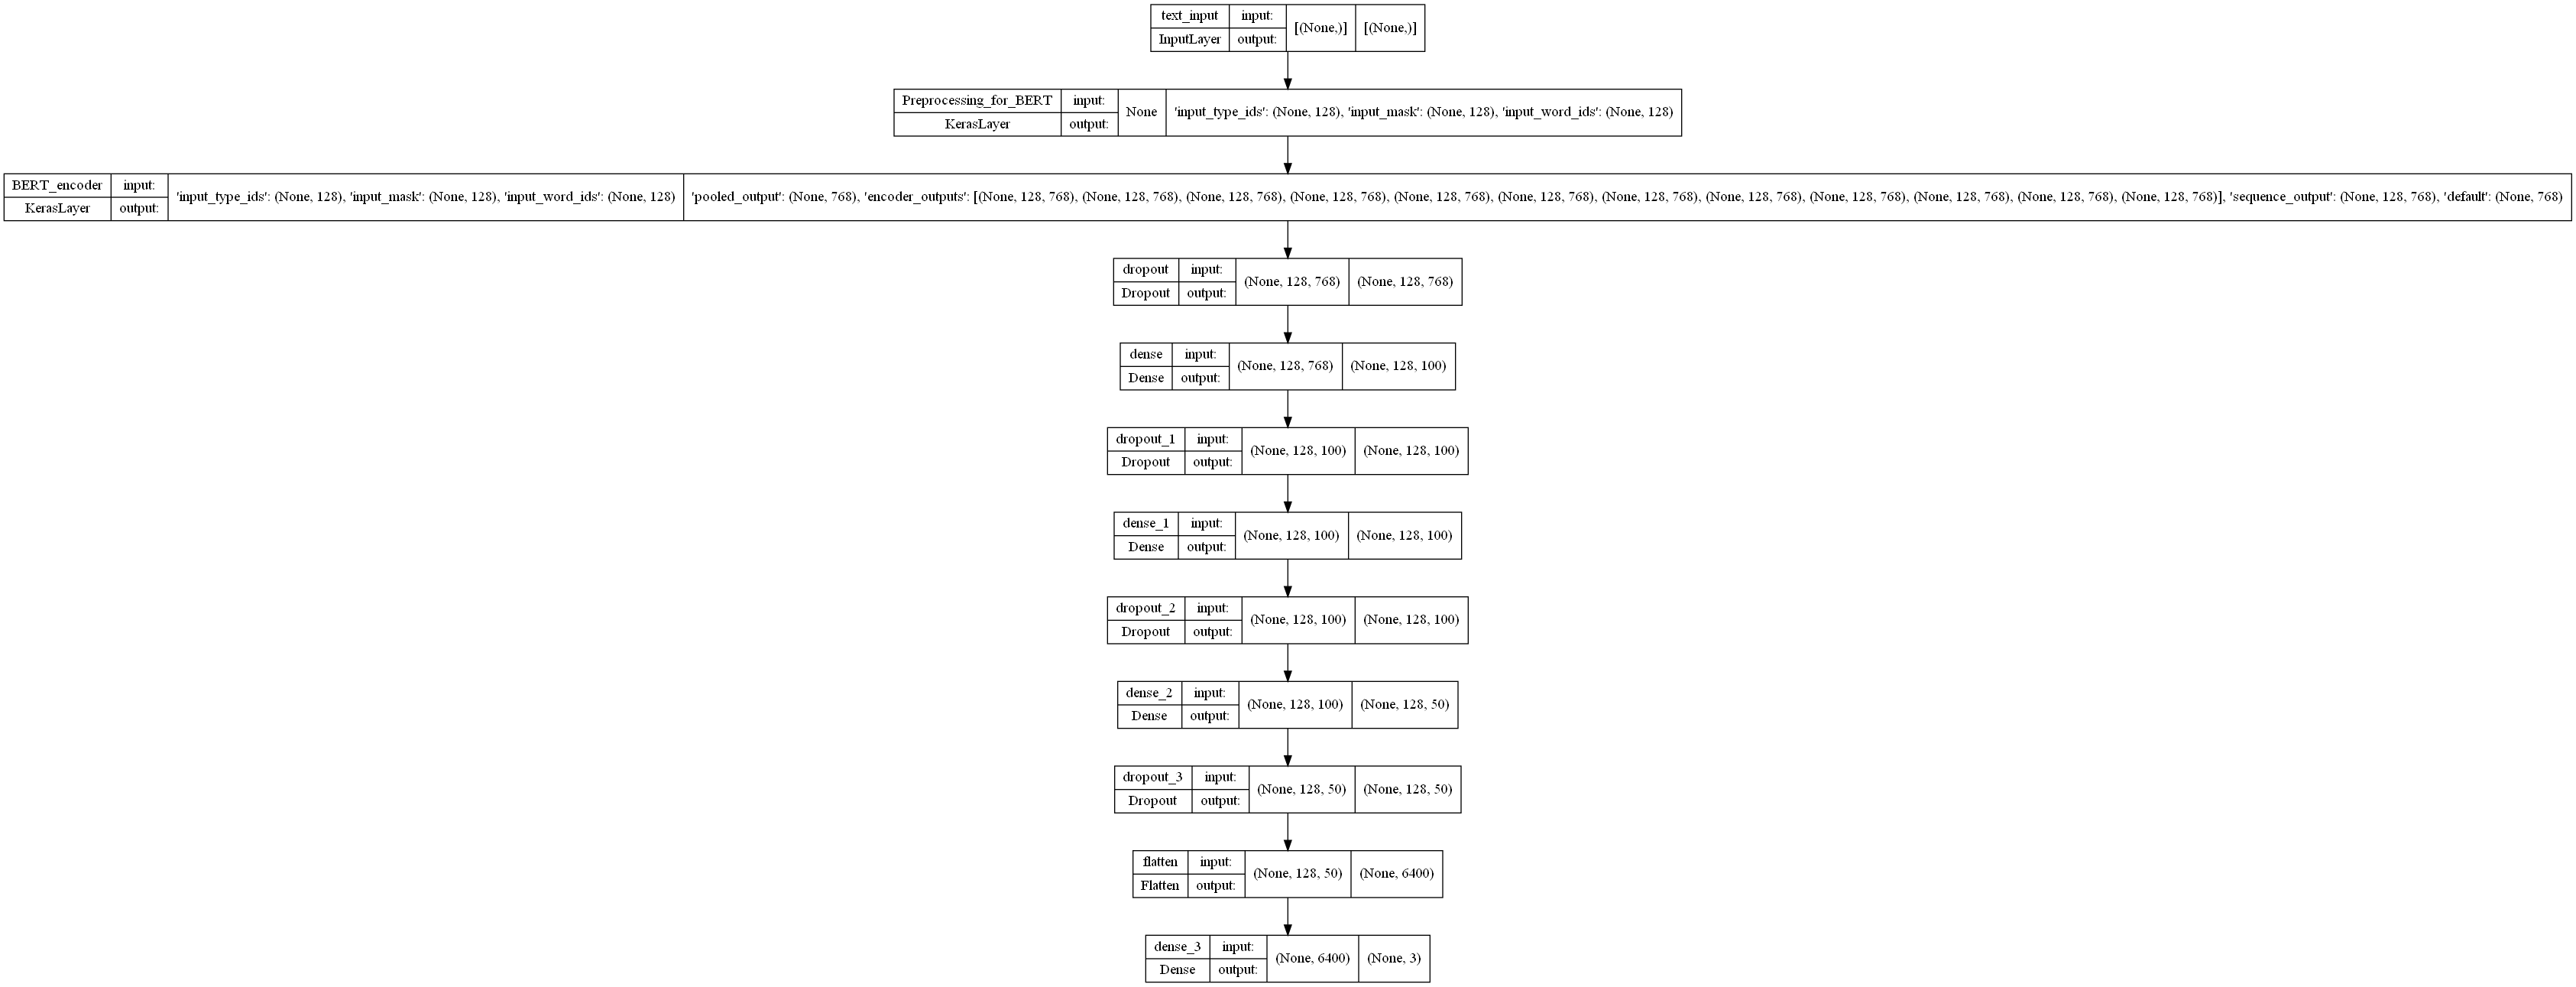

In [63]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='./Model Output/model1_structure.png', show_shapes=True)

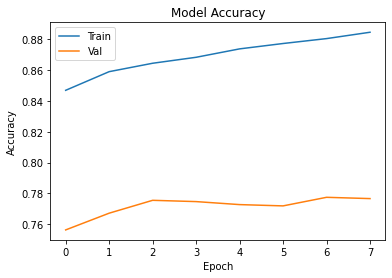

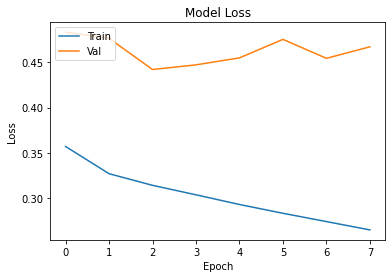

In [65]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()


plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()